In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tid_g=np.load('tid_g.npy')
k_g=np.load('k_g.npy')
index_g=np.load('index_g.npy')
abs_mag_g=np.load('/global/u1/z/zhaozhon/task/abs_mag_g.npy')
magerr_g_1=np.load('/global/u1/z/zhaozhon/task/magerr_g_1.npy')
z_g = np.load('/global/u1/z/zhaozhon/task/z_g.npy')
apr_mag_g=np.load('/global/u1/z/zhaozhon/task/apr_mag_g.npy')

In [3]:
index_g2 = np.isnan(k_g) | np.isneginf(k_g)
print(np.max(k_g[~index_g2]))
print(np.min(k_g[~index_g2]))

0.7099927636950163
-0.6747415856526864


In [4]:
filtered_abs_mag_g = abs_mag_g[index_g][~index_g2]
filtered_apr_mag_g = apr_mag_g[index_g][~index_g2]
filtered_magerr_g_1 = magerr_g_1[index_g][~index_g2]
filtered_z_g = z_g[index_g][~index_g2]
tid_g = tid_g[~index_g2]
k_g = k_g[~index_g2]

In [5]:
k_abs_mag_g = filtered_abs_mag_g - k_g

In [31]:
print(filtered_z_g)
print(k_abs_mag_g)

[2.13902358 2.2731864  2.28902289 ... 2.61738098 2.15197294 2.55964056]
[-26.8226332  -24.99324349 -25.81897143 ... -26.58326956 -25.43343106
 -25.81347774]


In [7]:

# Define the Chebyshev polynomials of the first kind
def T0(x):
    return 1

def T1(x):
    return x

def T2(x):
    return 2*x**2 - 1

# Define the parameter functions based on the equations given
def gamma1(z, a0, a1, a2):
    return a0 * T0(1 + z) + a1 * T1(1 + z) + a2 * T2(1 + z)

def gamma2(z, b0, b1, b2, z_ref):
    return 2 * b0 / (((1 + z) / (1 + z_ref))**b1 + ((1 + z) / (1 + z_ref))**b2)

def log_L_star(z, c0, c1, c2, z_ref):
    return 2 * c0 / (((1 + z) / (1 + z_ref))**c1 + ((1 + z) / (1 + z_ref))**c2)

def log_phi_star(z, d0, d1, z_ref):
    return d0 * T0(1 + z) + d1 * T1(1 + z)

def abs_mag_to_L(M):
    M_sun = 4.83  # Standard absolute magnitude of the Sun
    L_sun = 3.828e26  # Standard luminosity of the Sun in Watts
    # Calculate luminosity
    L = 10**((M_sun - M) / 2.5) * L_sun
    return L

# Define the luminosity function using the parameters from Best-fit A
def phi_bol(M,z, params, z_ref):
    L = abs_mag_to_L(-26.8226332)
    gamma1_val = gamma1(z, params_A['a0'], params_A['a1'], params_A['a2'])
    gamma2_val = gamma2(z, params_A['b0'], params_A['b1'], params_A['b2'], z_ref)
    L_star_val = 10**log_L_star(z, params_A['c0'], params_A['c1'], params_A['c2'], z_ref)
    phi_star_val = 10**log_phi_star(z, params_A['d0'], params_A['d1'], z_ref)
    phi_bol_value_corrected = phi_star_val / ((L / L_star_val)**gamma1_val + (L / L_star_val)**gamma2_val)
    return phi_bol_value_corrected

# Parameters for Best-fit A
params_A = {
    'a0': 0.8569,
    'a1': -0.2614,
    'a2': 0.0200,
    'b0': 2.5375,
    'b1': -1.0425,
    'b2': 1.1201,
    'c0': 13.0088,
    'c1': -0.5759,
    'c2': 0.4554,
    'd0': -3.5426,
    'd1': -0.3936
}
z_ref = 2 # reference redshift value is not given, assuming z_ref = 1

# Define the luminosity for which we want to compute the luminosity function

In [33]:
density = phi_bol(k_abs_mag_g ,filtered_z_g, params_A, z_ref)

In [34]:
print(density)

[8.46238202e-72 1.79742869e-71 1.99407758e-71 ... 3.07044903e-70
 9.00638528e-72 1.76874688e-70]


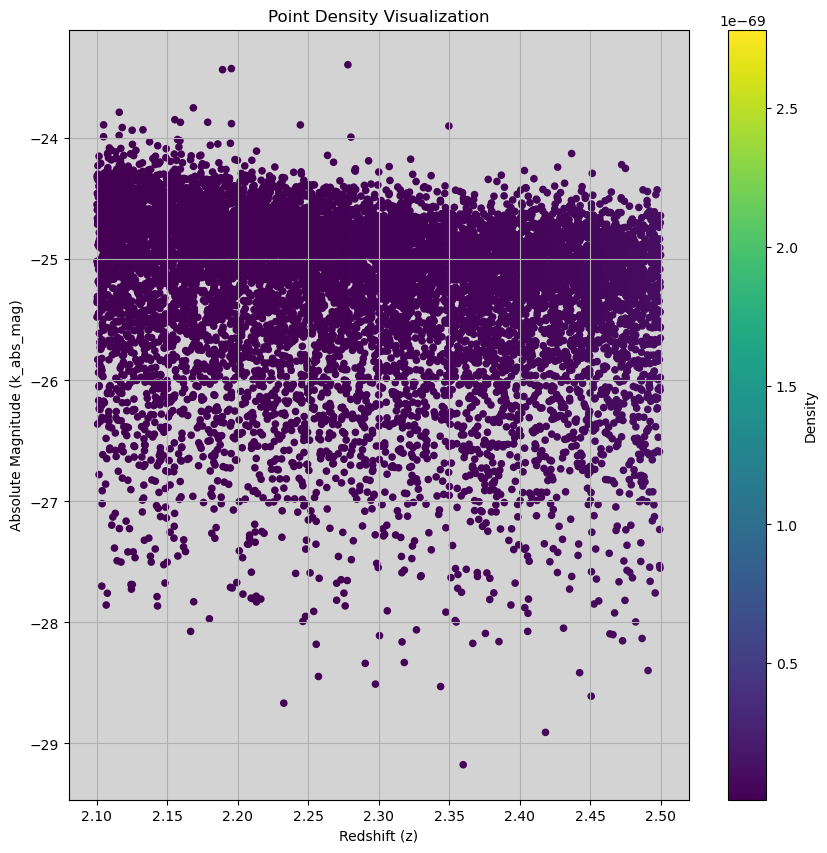

In [38]:
plt.figure(figsize=(10, 10))
indice = filtered_z_g < 2.5
scatter = plt.scatter(filtered_z_g[indice] , k_abs_mag_g[indice], c=density[indice], cmap='viridis', s=20, norm=plt.Normalize(vmin=np.percentile(density, 5), vmax=np.percentile(density, 95)))
plt.colorbar(scatter, label='Density')
plt.xlabel('Redshift (z)')
plt.ylabel('Absolute Magnitude (k_abs_mag)')
plt.title('Point Density Visualization')
plt.gca().set_facecolor('lightgrey')  # Adjust background color for contrast
#plt.xlim([min(filtered_z_g), max(filtered_z_g)])  # Adjust as needed
#plt.ylim([min(k_abs_mag_g), max(k_abs_mag_g)])    # Adjust as needed
plt.grid()
plt.show()

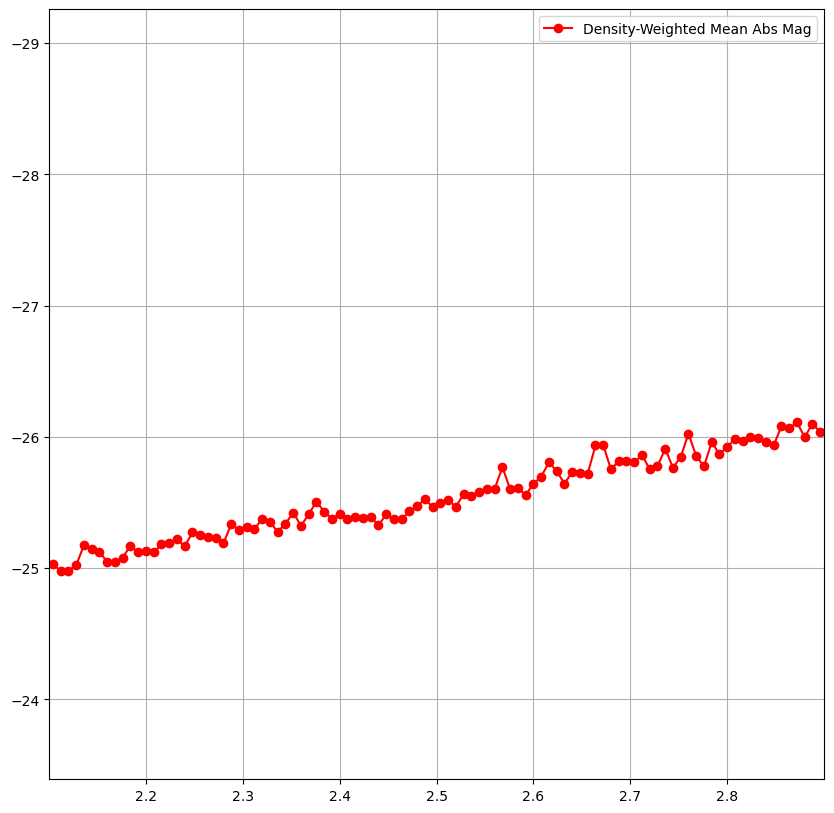

In [36]:
plt.figure(figsize=(10, 10))
# Define bin edges for redshift (z)
bins = np.linspace(min(filtered_z_g), max(filtered_z_g), 101)  # 100 bins means 101 edges
bin_indices = np.digitize(filtered_z_g, bins)

# Calculate the density-weighted sum of absolute magnitude for each bin
weighted_sums = np.array([np.sum(k_abs_mag_g[bin_indices == i] * density[bin_indices == i]) for i in range(1, len(bins))])

# Calculate the sum of densities for each bin
density_sums = np.array([np.sum(density[bin_indices == i]) for i in range(1, len(bins))])

# Avoid division by zero for bins with no density
with np.errstate(divide='ignore', invalid='ignore'):
    expectation_values = np.where(density_sums != 0, weighted_sums / density_sums, np.nan)

# Calculate the center of each bin for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Overlay the expectation values
plt.plot(bin_centers, expectation_values, 'ro-', label='Density-Weighted Mean Abs Mag')
plt.legend()

# Adjust the x and y limits to make sure all data and lines are visible
plt.xlim([min(filtered_z_g), max(filtered_z_g)])
plt.ylim([max(k_abs_mag_g), min(k_abs_mag_g)])  # Inverted because magnitude scales are often plotted high-to-low
plt.grid()
plt.show()